In [15]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

In [7]:
url = 'https://lazyprogrammer.me/course_files/AirlineTweets.csv'
df = pd.read_csv(url, encoding='ISO-8859-1')

In [11]:
print(df.head())

# Step 3: Preprocessing - drop missing, encode sentiment
df = df[['text', 'airline_sentiment']].dropna()
df = df[df['airline_sentiment'] != 'neutral']  # Keep only positive/negative
df['label'] = df['airline_sentiment'].map({'positive': 1, 'negative': 0})

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=1)

# Step 5: Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 6: Train logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

LogisticRegression()

In [17]:
# Step 7: Evaluation
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

F1 Score: 0.7579462102689487
AUC Score: 0.9606280505245287

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1837
           1       0.90      0.66      0.76       472

    accuracy                           0.91      2309
   macro avg       0.91      0.82      0.85      2309
weighted avg       0.91      0.91      0.91      2309



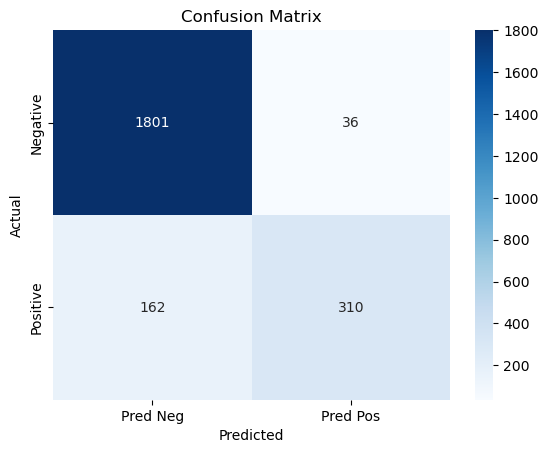

In [19]:
# Step 8: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Pred Neg", "Pred Pos"]),
           annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
# Step 9: Predict new sentiment
def predict_sentiment(text):
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0][1]
    label = "Positive" if pred == 1 else "Negative"
    return f"{label} (Confidence: {prob:.2f})"

# Example:
print(predict_sentiment("I had a great flight with Delta!"))
print(predict_sentiment("The service was terrible and delayed."))

Positive (Confidence: 0.61)
Negative (Confidence: 0.01)


## Binary Labels & Model Interpretation

In [ ]:
# Exercise: print the most-wrong tweets for both classes
# i.e. find a negative review where p(y = 1 | x) is closest to 1
#      find a positive review where p(y = 1 | x) is closest to 0

# Exercise: set class_weight='balanced'

In [23]:
# Get predicted probabilities
y_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Convert X_test to a DataFrame for easier access
X_test_df = X_test.reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

# Most-wrong negative tweet (true label = 0, prob of 1 = highest)
mask_neg = (y_test_df == 0)
wrong_neg_conf = y_probs[mask_neg]
wrong_neg_tweets = X_test_df[mask_neg]
most_wrong_neg_index = np.argmax(wrong_neg_conf)

print("🔴 Most-wrong negative tweet (predicted as very positive):")
print("Prob(positive):", wrong_neg_conf[most_wrong_neg_index])
print("Text:", wrong_neg_tweets.iloc[most_wrong_neg_index])

# Most-wrong positive tweet (true label = 1, prob of 1 = lowest)
mask_pos = (y_test_df == 1)
wrong_pos_conf = y_probs[mask_pos]
wrong_pos_tweets = X_test_df[mask_pos]
most_wrong_pos_index = np.argmin(wrong_pos_conf)

print("\n🟢 Most-wrong positive tweet (predicted as very negative):")
print("Prob(positive):", wrong_pos_conf[most_wrong_pos_index])
print("Text:", wrong_pos_tweets.iloc[most_wrong_pos_index])


🔴 Most-wrong negative tweet (predicted as very positive):
Prob(positive): 0.8596763290952003
Text: @VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS

🟢 Most-wrong positive tweet (predicted as very negative):
Prob(positive): 0.0424099580446938
Text: @USAirways - done :)


In [29]:
model_balanced = LogisticRegression(class_weight='balanced')
model_balanced.fit(X_train_tfidf, y_train)

# Predictions
y_pred_bal = model_balanced.predict(X_test_tfidf)
y_prob_bal = model_balanced.predict_proba(X_test_tfidf)[:, 1]

# Metrics
print("\n🧪 Performance WITH class_weight='balanced':")
print("F1 Score:", f1_score(y_test, y_pred_bal))
print("AUC Score:", roc_auc_score(y_test, y_prob_bal))
print(classification_report(y_test, y_pred_bal))


🧪 Performance WITH class_weight='balanced':
F1 Score: 0.8171828171828172
AUC Score: 0.9614930385761603
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1837
           1       0.77      0.87      0.82       472

    accuracy                           0.92      2309
   macro avg       0.87      0.90      0.88      2309
weighted avg       0.93      0.92      0.92      2309



![](https://deeplearningcourses.com/notebooks_v3_pxl?sc=vr6jNPyi5aj-nePG-Zpgog&n=Sentiment+Analysis)